In [69]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist as fm

In [70]:
(X, y), (X_test, y_test) = fm.load_data()

In [71]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

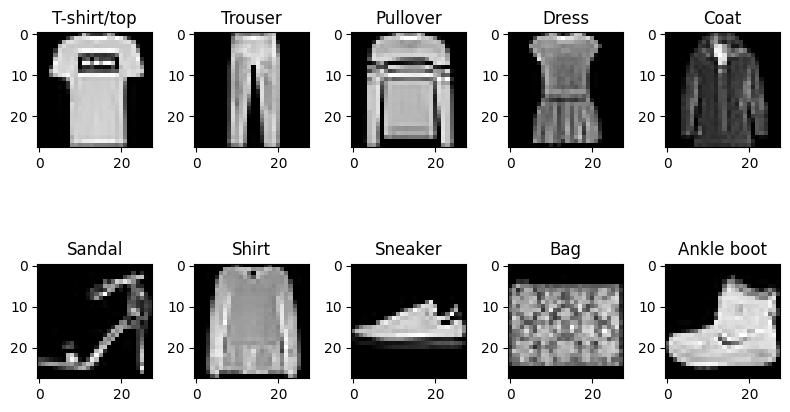

In [72]:
class_images= np.zeros((10,X[0].shape[0], X[0].shape[1]))
for i in range(10):
  class_images[i, :, :]= X[np.where(y==i)[0][0]]

fig = plt.figure(figsize=(8, 5))
for i, image in enumerate(class_images):
    ax = fig.add_subplot(2, 5, i+1)
    ax.set_title(f'{class_names[i]}')
    ax.imshow(image, cmap='gray')
plt.tight_layout()
plt.show()

In [73]:
class Deep_Neural_Networks:
  def __init__(self, weight_init_mode, dimensions, batch_size, af_type, loss_type, learning_rate, lambda_reg):
    self.weight_init_mode= weight_init_mode
    self.af_choice= af_type
    self.loss_type= loss_type
    self.learning_rate= learning_rate
    self.batch_size= batch_size
    self.lambda_reg= lambda_reg
    self.dimensions= dimensions

  def activation_function(self, x):
    if self.af_choice=='sigmoid':
      return 1 / (1 + np.exp(-x))

    elif self.af_choice=='ReLU':
      return np.maximum(0, x)

    elif self.af_choice=='tanh':
      return np.tanh(x)

  def activation_function_derivative(self, x):
    if self.af_choice=='sigmoid':
      sigmoid= lambda x: 1/(1 + np.exp(-x))
      return sigmoid(x) * (1- sigmoid(x))

    elif self.af_choice=='ReLU':
      return 1*(x>0)

    elif self.af_choice=='tanh':
      return 1- (np.tanh(x))**2

  def softmax_function(self, x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

  def softmax_derivative(self, x):
    softmax= lambda x: np.exp(x) / np.sum(np.exp(x), axis=0)
    return softmax(x) * (1-softmax(x))

  def initial_parameters(self):
    parameters= dict()
    for i in range(1,len(self.dimensions)):
      if self.weight_init_mode == 'random':
          parameters["W" + str(i)] = 0.01*np.random.randn(self.dimensions[i], self.dimensions[i-1])  #0.01 is the scaling factor to ensure smaller initialization weights
      elif self.weight_init_mode == 'Xavier':
          parameters["W" + str(i)] = np.random.randn(self.dimensions[i], self.dimensions[i-1])*np.sqrt(2/(self.dimensions[i] + self.dimensions[i-1]))
      parameters["b" + str(i)] = np.zeros((self.dimensions[i],1))
    return parameters

  def compute_true_error(self, y, y_hat, parameters):
    L= len(parameters)//2
    if self.loss_type == 'cross_entropy':
      Loss = - np.sum(y * np.log2(y_hat))/y.shape[1]
    elif self.loss_type == 'mean_squared_error':
      Loss = (1/2) * np.sum((y-y_hat)**2)/y.shape[1]

    penalty = 0                                                               # account for regularization to avoid overfit of data - L2 norm regularization
    for i in range(1,L+1) :
      penalty+= (np.linalg.norm(parameters["W"+str(i)])**2)
    true_error= Loss + (self.lambda_reg/2)*penalty
    return true_error

  def compute_test_error(self, y, y_hat):
    if self.loss_type == 'cross_entropy':
      Loss = - np.sum(y * np.log2(y_hat))/y.shape[1]
    elif self.loss_type == 'mean_squared_error':
      Loss = (1/2) * np.sum((y-y_hat)**2)/y.shape[1]
    return Loss

  def Feed_Forward_Network(self, X_data, parameters):
    L= len(parameters)//2   # Number of layers
    a= [None] * L
    h= [None] * L

    h[0]= X_data # It can be vector (one sample) or can be a matrix (Features x Samples)
    for i in range(1, L):
      a[i-1]= parameters["W" + str(i)] @ h[i-1] + parameters["b" + str(i)]
      h[i]= self.activation_function(a[i-1])
    a[L-1]= parameters["W" + str(L)] @ h[L-1] + parameters["b" + str(L)]
    y_hat= self.softmax_function(a[L-1])
    return y_hat, a, h

  def Back_Propagation(self, y_hat, y, a, h, parameters):
    gradients={}
    L= len(parameters)//2

    if self.loss_type=='cross_entropy':
      gradients["grad(Loss)" + str(L)]= y_hat - y
    elif self.loss_type=='mean_squared_error':
      gradients["grad(Loss)" + str(L)]= (y_hat - y) * self.softmax_derivative(a[L-1])

    for i in range(L, 0, -1):
      gradients["grad_W" + str(i)]= (gradients["grad(Loss)" + str(i)] @  h[i-1].T + self.lambda_reg * parameters["W" + str(i)])/self.batch_size
      gradients['grad_b' + str(i)]= np.sum(gradients["grad(Loss)" + str(i)], axis=1).reshape(-1,1)/ self.batch_size

      if i>1:
        gradients["grad(Loss)" + str(i-1)]= (parameters["W"+str(i)].T @ gradients["grad(Loss)" + str(i)]) * self.activation_function_derivative(a[i-2])
    return gradients

In [74]:
# Split 80 percent of data to Train Data, and 20 percent to Test Data
def data_split(X, y, size, random_state=None):
  if random_state:
    np.random.seed(random_state)

  # Shuffle indices
  indices = np.arange(len(X))
  np.random.shuffle(indices)

  # Calculate the number of samples for the test set
  num_train_samples = int(len(X) * size)

  # Split indices into train and test sets
  train_indices = indices[:num_train_samples]
  val_indices = indices[num_train_samples:]

  # Split the data based on the indices
  X_train = X[train_indices]
  y_train = y[train_indices]
  X_validate = X[val_indices]
  y_validate = y[val_indices]

  return X_train, y_train, X_validate, y_validate

In [75]:
# Reshaping the data matrices
X = X.reshape(X.shape[0], 784)
X_test = X_test.reshape(X_test.shape[0], 784)
# Normalizing the pixel intensities
X = X/255.0
X_test = X_test/255.0

# X_mean= np.mean(X, axis=0)
# X_std= np.std(X, axis=0)
# X= (X-X_mean)/X_std

# X_test_mean= np.mean(X, axis=0)
# X_test_std= np.std(X, axis=0)
# X_test= (X_test-X_test_mean)/X_test_std

# Split the X_train into a training set and validation set
X_train, y_train, X_val, y_val = data_split(X, y, size=0.8, random_state=42)

print("Dimension for the train dataset: ", X_train.shape)
print("Dimension for the validation data: ", X_val.shape)
print("Dimension for the test data: ", X_test.shape)

Dimension for the train dataset:  (48000, 784)
Dimension for the validation data:  (12000, 784)
Dimension for the test data:  (10000, 784)


In [76]:
no_of_classes= len(class_names)
N_train= X_train.shape[0]
N_val= X_val.shape[0]
N_test= X_test.shape[0]

#one hot encoding
Y_train= np.zeros((no_of_classes, N_train))
Y_val= np.zeros((no_of_classes, N_val))
Y_test= np.zeros((no_of_classes, N_test))

Y_train[y_train, range(N_train)]=1
Y_val[y_val, range(N_val)]=1
Y_test[y_test, range(N_test)]=1

print("Dimension for the train label dataset: ", Y_train.shape)
print("Dimension for the validation label data: ", Y_val.shape)
print("Dimension for the test label data: ", Y_test.shape)

Dimension for the train label dataset:  (10, 48000)
Dimension for the validation label data:  (10, 12000)
Dimension for the test label data:  (10, 10000)


In [77]:
X_train= X_train.T
X_val= X_val.T
X_test= X_test.T

In [78]:
def Data_Preprocessing(X, y, X_test, y_test, class_names):
  # Reshaping the data matrices
  X = X.reshape(X.shape[0], 784)
  X_test = X_test.reshape(X_test.shape[0], 784)
  # Normalizing the pixel intensities
  X = X/255.0
  X_test = X_test/255.0
  X_train, y_train, X_val, y_val = data_split(X, y, size=0.8, random_state=42)

  no_of_classes= len(class_names)
  N_train= X_train.shape[0]
  N_val= X_val.shape[0]
  N_test= X_test.shape[0]

  #one hot encoding
  Y_train= np.zeros((no_of_classes, N_train))
  Y_val= np.zeros((no_of_classes, N_val))
  Y_test= np.zeros((no_of_classes, N_test))

  Y_train[y_train, range(N_train)]=1
  Y_val[y_val, range(N_val)]=1
  Y_test[y_test, range(N_test)]=1

  X_train= X_train.T
  X_val= X_val.T
  X_test= X_test.T

  return X_train, X_val, X_test, Y_train, Y_val, Y_test

In [79]:
class model_fit(Deep_Neural_Networks):
  def __init__(self, X_train, Y_train, X_val, Y_val, learning_rate,lambda_reg, af_type, weight_init_mode, optimizer, batch_size, loss_type, epochs, dimensions, beta, beta_1, beta_2):
    self.X_train= X_train
    self.Y_train= Y_train
    self.X_val= X_val
    self.Y_val= Y_val
    self.optimizer= optimizer
    self.epochs= epochs
    self.logs= True
    self.beta=beta
    self.beta_1= beta_1
    self.beta_2= beta_2
    self.t= 1
    self.epsilon=1e-6
    self.accuracy_train=[]
    self.accuracy_val=[]
    self.loss_train=[]
    self.loss_val=[]
    super().__init__(weight_init_mode, dimensions, batch_size, af_type, loss_type, learning_rate, lambda_reg)

  def initial_history(self):
    parameters={}
    for i in range(1, len(self.dimensions)):
      parameters["W" + str(i)]= np.zeros((self.dimensions[i], self.dimensions[i-1]))
      parameters["b" + str(i)]= np.zeros((self.dimensions[i], 1))
    return parameters
  def initial_gradients(self):
    gradients= {}
    for i in range(1, len(self.dimensions)):
      gradients["grad_W" + str(i)] = np.zeros((self.dimensions[i], self.dimensions[i-1]))
      gradients["grad_b" + str(i)] = np.zeros((self.dimensions[i], 1))
    return gradients

  def stochastic_gradient_descent(self):
    parameters=self.initial_parameters()
    L= len(parameters)//2

    for epoch in range(self.epochs):
      for i in range(0, self.X_train.shape[1], self.batch_size):
        y_hat, a, h= self.Feed_Forward_Network(self.X_train[:, i:i+self.batch_size], parameters)
        gradients= self.Back_Propagation(y_hat, self.Y_train[:, i:i+self.batch_size], a, h, parameters)
        for l in range(1, L + 1):
          parameters["W" + str(l)] = parameters["W" + str(l)] - self.learning_rate * gradients["grad_W" + str(l)]
          parameters["b" + str(l)] = parameters["b" + str(l)] - self.learning_rate * gradients["grad_b" + str(l)]

      if self.logs==True:
        Y_hat_train, _, _= self.Feed_Forward_Network(self.X_train, parameters)
        self.loss_train.append(self.compute_true_error(self.Y_train, Y_hat_train, parameters))
        Y_hat_val,_,_= self.Feed_Forward_Network(self.X_val, parameters)
        self.loss_val.append(self.compute_test_error(self.Y_val, Y_hat_val))

        # Compute the accuracy on the test set
        train_acc = (np.argmax(self.Y_train, axis=0) == np.argmax(Y_hat_train, axis=0)).mean() *100
        validation_acc= (np.argmax(self.Y_train, axis=0) == np.argmax(Y_hat_train, axis=0)).mean() *100

        self.accuracy_train.append(train_acc)
        self.accuracy_val.append(validation_acc)
        #wandb.log({"Accuracy_Train":self.accuracy_train[-1],"Loss_Train":self.loss_train[-1],"Accuracy_val":self.accuracy_val[-1],"Loss_val": self.loss_val[-1]})
        print(f"For the epoch: {epoch},training loss: {self.loss_train[-1]}, validation loss: {self.loss_val[-1]}, training accuracy: {self.accuracy_train[-1]}% and validation accuracy: {self.accuracy_val[-1]}%")
    return parameters

  def momentum_gradient_descent(self):
    parameters=self.initial_parameters()
    L= len(parameters)//2
    update_history= self.initial_history()
    for epoch in range(self.epochs):
      for i in range(0, self.X_train.shape[1], self.batch_size):
        y_hat, a, h= self.Feed_Forward_Network(self.X_train[:, i:i+self.batch_size], parameters)
        gradients= self.Back_Propagation(y_hat, self.Y_train[:, i:i+self.batch_size], a, h, parameters)

        for l in range(1, L + 1):
          update_history["W" + str(l)]= self.beta*update_history["W" + str(l)] + gradients["grad_W" + str(l)]
          update_history["b" + str(l)]= self.beta*update_history["b" + str(l)] + gradients["grad_b" + str(l)]
          parameters["W" + str(l)] = parameters["W" + str(l)] - self.learning_rate*update_history["W" + str(l)]
          parameters["b" + str(l)] = parameters["b" + str(l)] - self.learning_rate*update_history["b" + str(l)]

      if self.logs==True:
        Y_hat_train, _, _= self.Feed_Forward_Network(self.X_train, parameters)
        self.loss_train.append(self.compute_true_error(self.Y_train, Y_hat_train, parameters))
        Y_hat_val,_,_= self.Feed_Forward_Network(self.X_val, parameters)
        self.loss_val.append(self.compute_test_error(self.Y_val, Y_hat_val))

        # Compute the accuracy on the test set
        train_acc = (np.argmax(self.Y_train, axis=0) == np.argmax(Y_hat_train, axis=0)).mean() *100
        validation_acc= (np.argmax(self.Y_train, axis=0) == np.argmax(Y_hat_train, axis=0)).mean() *100

        self.accuracy_train.append(train_acc)
        self.accuracy_val.append(validation_acc)
        #wandb.log({"Accuracy_Train":self.accuracy_train[-1],"Loss_Train":self.loss_train[-1],"Accuracy_val":self.accuracy_val[-1],"Loss_val": self.loss_val[-1]})
        print(f"For the epoch: {epoch},training loss: {self.loss_train[-1]}, validation loss: {self.loss_val[-1]}, training accuracy: {self.accuracy_train[-1]}% and validation accuracy: {self.accuracy_val[-1]}%")
    return parameters

  def nestorov_gradient_descent(self):
    look_ahead=dict()
    parameters=self.initial_parameters()
    L= len(parameters)//2
    update_history= self.initial_history()
    for epoch in range(self.epochs):
      for i in range(0, self.X_train.shape[1], self.batch_size):
        for l in range(1, L+1):
          look_ahead["W" + str(l)] = parameters["W" + str(l)] - self.beta*update_history["W" + str(l)]
          look_ahead["b" + str(l)] = parameters["b" + str(l)] - self.beta*update_history["b" + str(l)]
        y_hat, a, h= self.Feed_Forward_Network(self.X_train[:, i:i+self.batch_size], look_ahead)
        gradients= self.Back_Propagation(y_hat, self.Y_train[:, i:i+self.batch_size], a, h, look_ahead)

        for l in range(1, L + 1):
          update_history["W" + str(l)]= self.beta*update_history["W" + str(l)] + gradients["grad_W" + str(l)]
          update_history["b" + str(l)]= self.beta*update_history["b" + str(l)] + gradients["grad_b" + str(l)]
          parameters["W" + str(l)] = parameters["W" + str(l)] - self.learning_rate*update_history["W" + str(l)]
          parameters["b" + str(l)] = parameters["b" + str(l)] - self.learning_rate*update_history["b" + str(l)]

      if self.logs==True:
        Y_hat_train, _, _= self.Feed_Forward_Network(self.X_train, parameters)
        self.loss_train.append(self.compute_true_error(self.Y_train, Y_hat_train, parameters))
        Y_hat_val,_,_= self.Feed_Forward_Network(self.X_val, parameters)
        self.loss_val.append(self.compute_test_error(self.Y_val, Y_hat_val))

        # Compute the accuracy on the test set
        train_acc = (np.argmax(self.Y_train, axis=0) == np.argmax(Y_hat_train, axis=0)).mean() *100
        validation_acc= (np.argmax(self.accuracy_valY_train, axis=0) == np.argmax(Y_hat_train, axis=0)).mean() *100

        self.accuracy_train.append(train_acc)
        self.accuracy_val.append(validation_acc)
        #wandb.log({"Accuracy_Train":self.accuracy_train[-1],"Loss_Train":self.loss_train[-1],"Accuracy_val":self.accuracy_val[-1],"Loss_val": self.loss_val[-1]})
        print(f"For the epoch: {epoch},training loss: {self.loss_train[-1]}, validation loss: {self.loss_val[-1]}, training accuracy: {self.accuracy_train[-1]}% and validation accuracy: {self.accuracy_val[-1]}%")
    return parameters

  def RMSprop_Gradient_Descent(self):
    parameters=self.initial_parameters()
    L= len(parameters)//2
    update_history= self.initial_history()
    for epoch in range(self.epochs):
      for i in range(0, self.X_train.shape[1], self.batch_size):
        y_hat, a, h= self.Feed_Forward_Network(self.X_train[:, i:i+self.batch_size], parameters)
        gradients= self.Back_Propagation(y_hat, self.Y_train[:, i:i+self.batch_size], a, h, parameters)
        for l in range(1, L + 1):
          update_history["W" + str(l)]= self.beta*update_history["W" + str(l)] + (1-self.beta)*gradients["grad_W" + str(l)]**2
          update_history["b" + str(l)]= self.beta*update_history["b" + str(l)] + (1-self.beta)*gradients["grad_b" + str(l)]**2
          parameters["W" + str(l)] = parameters["W" + str(l)] - self.learning_rate*gradients["grad_W" + str(l)]/(np.sqrt(update_history["W" + str(l)] + self.epsilon))
          parameters["b" + str(l)] = parameters["b" + str(l)] - self.learning_rate*gradients["grad_b" + str(l)]/(np.sqrt(update_history["b" + str(l)] + self.epsilon))

      if self.logs==True:
        Y_hat_train, _, _= self.Feed_Forward_Network(self.X_train, parameters)
        self.loss_train.append(self.compute_true_error(self.Y_train, Y_hat_train, parameters))
        Y_hat_val,_,_= self.Feed_Forward_Network(self.X_val, parameters)
        self.loss_val.append(self.compute_test_error(self.Y_val, Y_hat_val))

        # Compute the accuracy on the test set
        train_acc = (np.argmax(self.Y_train, axis=0) == np.argmax(Y_hat_train, axis=0)).mean() *100
        validation_acc= (np.argmax(self.Y_train, axis=0) == np.argmax(Y_hat_train, axis=0)).mean() *100

        self.accuracy_train.append(train_acc)
        self.accuracy_val.append(validation_acc)
        #wandb.log({"Accuracy_Train":self.accuracy_train[-1],"Loss_Train":self.loss_train[-1],"Accuracy_val":self.accuracy_val[-1],"Loss_val": self.loss_val[-1]})
        print(f"For the epoch: {epoch},training loss: {self.loss_train[-1]}, validation loss: {self.loss_val[-1]}, training accuracy: {self.accuracy_train[-1]}% and validation accuracy: {self.accuracy_val[-1]}%")
    return parameters

  def Adam(self):
    parameters=self.initial_parameters()
    L= len(parameters)//2
    update_history= self.initial_history()
    momentum= self.initial_history()
    for epoch in range(self.epochs):
      for i in range(0, self.X_train.shape[1], self.batch_size):
        y_hat, a, h= self.Feed_Forward_Network(self.X_train[:, i:i+self.batch_size], parameters)
        gradients= self.Back_Propagation(y_hat, self.Y_train[:, i:i+self.batch_size], a, h, parameters)
        for i in range(1, L+1):
          momentum["W" + str(i)] = self.beta_1*momentum["W"+str(i)] + (1-self.beta_1)*gradients["grad_W"+str(i)]
          momentum["b" + str(i)] = self.beta_1*momentum["b"+str(i)] + (1-self.beta_1)*gradients["grad_b"+str(i)]
          momentum_w_hat = momentum["W" + str(i)]/(1.0 - self.beta_1**(epoch+1))
          momentum_b_hat = momentum["b" + str(i)]/(1.0 - self.beta_1**(epoch+1))

          update_history["W" + str(i)] = self.beta_2*update_history["W"+str(i)] + (1-self.beta_2)*gradients["grad_W"+str(i)]**2
          update_history["b" + str(i)] = self.beta_2*update_history["b"+str(i)] + (1-self.beta_2)*gradients["grad_b"+str(i)]**2
          update_history_w_hat = update_history["W" + str(i)]/(1.0 - self.beta_2**(epoch+1))
          update_history_b_hat = update_history["b" + str(i)]/(1.0 - self.beta_2**(epoch+1))

          parameters["W"+str(i)] = parameters["W"+str(i)] - (self.learning_rate * momentum_w_hat)/np.sqrt(update_history_w_hat + self.epsilon)
          parameters["b"+str(i)] = parameters["b"+str(i)] - (self.learning_rate * momentum_b_hat)/np.sqrt(update_history_b_hat + self.epsilon)

      if self.logs==True:
        Y_hat_train, _, _= self.Feed_Forward_Network(self.X_train, parameters)
        self.loss_train.append(self.compute_true_error(self.Y_train, Y_hat_train, parameters))
        Y_hat_val,_,_= self.Feed_Forward_Network(self.X_val, parameters)
        self.loss_val.append(self.compute_test_error(self.Y_val, Y_hat_val))

        # Compute the accuracy on the test set
        train_acc = (np.argmax(self.Y_train, axis=0) == np.argmax(Y_hat_train, axis=0)).mean() *100
        validation_acc= (np.argmax(self.Y_train, axis=0) == np.argmax(Y_hat_train, axis=0)).mean() *100

        self.accuracy_train.append(train_acc)
        self.accuracy_val.append(validation_acc)
        #wandb.log({"Accuracy_Train":self.accuracy_train[-1],"Loss_Train":self.loss_train[-1],"Accuracy_val":self.accuracy_val[-1],"Loss_val": self.loss_val[-1]})
        print(f"For the epoch: {epoch},training loss: {self.loss_train[-1]}, validation loss: {self.loss_val[-1]}, training accuracy: {self.accuracy_train[-1]}% and validation accuracy: {self.accuracy_val[-1]}%")
    return parameters
  def Nestorov_Adam(self):
    look_ahead=dict()
    parameters=self.initial_parameters()
    L= len(parameters)//2
    update_history= self.initial_history()
    momentum= self.initial_history()
    for epoch in range(self.epochs):
      for i in range(0, self.X_train.shape[1], self.batch_size):
        for l in range(1, L+1):
          look_ahead["W" + str(l)] = parameters["W" + str(l)] - self.beta*update_history["W" + str(l)]
          look_ahead["b" + str(l)] = parameters["b" + str(l)] - self.beta*update_history["b" + str(l)]
        y_hat, a, h= self.Feed_Forward_Network(self.X_train[:, i:i+self.batch_size], look_ahead)
        gradients= self.Back_Propagation(y_hat, self.Y_train[:, i:i+self.batch_size], a, h, look_ahead)

        for i in range(1, L+1):
          momentum["W" + str(i)] = self.beta_1*momentum["W"+str(i)] + (1-self.beta_1)*gradients["grad_W"+str(i)]
          momentum["b" + str(i)] = self.beta_1*momentum["b"+str(i)] + (1-self.beta_1)*gradients["grad_b"+str(i)]
          momentum_w_hat = momentum["W" + str(i)]/(1.0 - self.beta_1**(epoch+1))
          momentum_b_hat = momentum["b" + str(i)]/(1.0 - self.beta_1**(epoch+1))

          update_history["W" + str(i)] = self.beta_2*update_history["W"+str(i)] + (1-self.beta_2)*gradients["grad_W"+str(i)]**2
          update_history["b" + str(i)] = self.beta_2*update_history["b"+str(i)] + (1-self.beta_2)*gradients["grad_b"+str(i)]**2
          update_history_w_hat = update_history["W" + str(i)]/(1.0 - self.beta_2**(epoch+1))
          update_history_b_hat = update_history["b" + str(i)]/(1.0 - self.beta_2**(epoch+1))

          parameters["W"+str(i)] = parameters["W"+str(i)] - (self.learning_rate * momentum_w_hat)/np.sqrt(update_history_w_hat + self.epsilon)
          parameters["b"+str(i)] = parameters["b"+str(i)] - (self.learning_rate * momentum_b_hat)/np.sqrt(update_history_b_hat + self.epsilon)

      if self.logs==True:
        Y_hat_train, _, _= self.Feed_Forward_Network(self.X_train, parameters)
        self.loss_train.append(self.compute_true_error(self.Y_train, Y_hat_train, parameters))
        Y_hat_val,_,_= self.Feed_Forward_Network(self.X_val, parameters)
        self.loss_val.append(self.compute_test_error(self.Y_val, Y_hat_val))

        # Compute the accuracy on the test set
        train_acc = (np.argmax(self.Y_train, axis=0) == np.argmax(Y_hat_train, axis=0)).mean() *100
        validation_acc= (np.argmax(self.Y_train, axis=0) == np.argmax(Y_hat_train, axis=0)).mean() *100
        self.accuracy_train.append(train_acc)
        self.accuracy_val.append(validation_acc)

        #wandb.log({"Accuracy_Train":self.accuracy_train[-1],"Loss_Train":self.loss_train[-1],"Accuracy_val":self.accuracy_val[-1],"Loss_val": self.loss_val[-1]})
        print(f"For the epoch: {epoch},training loss: {self.loss_train[-1]}, validation loss: {self.loss_val[-1]}, training accuracy: {self.accuracy_train[-1]}% and validation accuracy: {self.accuracy_val[-1]}%")
    return parameters

  def fit(self):

    if self.optimizer=='sgd':
      parameters= self.stochastic_gradient_descent()
    elif self.optimizer=='momentum':
      parameters= self.momentum_gradient_descent()
    elif self.optimizer=='nag':
      parameters= self.nestorov_gradient_descent()
    elif self.optimizer=='rmsprop':
      parameters= self.RMSprop_Gradient_Descent()
    elif self.optimizer=='adam':
      parameters= self.Adam()
    elif self.optimizer=='nadam':
      parameters= self.Nestorov_Adam()
    return parameters

In [ ]:
from keras.datasets import fashion_mnist
(X, y), (X_test, y_test) = fashion_mnist.load_data()
class_names= ['No: 0', 'No: 1', 'No: 2', 'No: 3', 'No: 4', 'No: 5', 'No: 6', 'No: 7', 'No: 8', 'No: 9']
X_train, X_val, X_test, Y_train, Y_val, Y_test= Data_Preprocessing(X, y, X_test, y_test, class_names)

learning_rate= 0.001
af_type= 'tanh'
weight_init_mode= 'Xavier'
optimizer= 'rmsprop'
batch_size= 64
loss_type= 'cross_entropy'
epochs= 10
lambda_reg= 0.0005
K_classes= len(class_names)
N_neurons= 64
N_layers= 4
N_features= X_train.shape[0]
dimensions= [N_features] + [N_neurons]*N_layers + [K_classes]
fit_model = model_fit(X_train, Y_train, X_val, Y_val, learning_rate, lambda_reg, af_type, weight_init_mode, optimizer, batch_size, loss_type, epochs, dimensions, 0.5, 0.5, 0.5)
parameters= fit_model.fit()

## The three best hyperparameters obtained from the wandb

### Hyperparameter 1

In [80]:
from keras.datasets import mnist
(X, y), (X_test, y_test) = mnist.load_data()
class_names= ['No: 0', 'No: 1', 'No: 2', 'No: 3', 'No: 4', 'No: 5', 'No: 6', 'No: 7', 'No: 8', 'No: 9']
X_train, X_val, X_test, Y_train, Y_val, Y_test= Data_Preprocessing(X, y, X_test, y_test, class_names)

learning_rate= 0.001
af_type= 'tanh'
weight_init_mode= 'Xavier'
optimizer= 'rmsprop'
batch_size= 64
loss_type= 'cross_entropy'
epochs= 10
lambda_reg= 0.0005
K_classes= len(class_names)
N_neurons= 64
N_layers= 4
N_features= X_train.shape[0]
dimensions= [N_features] + [N_neurons]*N_layers + [K_classes]
fit_model = model_fit(X_train, Y_train, X_val, Y_val, learning_rate, lambda_reg, af_type, weight_init_mode, optimizer, batch_size, loss_type, epochs, dimensions, 0.5, 0.5, 0.5)
parameters= fit_model.fit()

For the epoch: 0,training loss: 0.3729207746113672, validation loss: 0.2930371194442927, training accuracy: 94.42083333333333% and validation accuracy: 94.42083333333333%
For the epoch: 1,training loss: 0.3011371457661248, validation loss: 0.22522296895990782, training accuracy: 96.20833333333333% and validation accuracy: 96.20833333333333%
For the epoch: 2,training loss: 0.27209043366297314, validation loss: 0.19912377436587167, training accuracy: 96.97083333333333% and validation accuracy: 96.97083333333333%
For the epoch: 3,training loss: 0.25547576097786906, validation loss: 0.18295318728715082, training accuracy: 97.50625000000001% and validation accuracy: 97.50625000000001%
For the epoch: 4,training loss: 0.2500717111451243, validation loss: 0.17857935100145172, training accuracy: 97.76458333333333% and validation accuracy: 97.76458333333333%
For the epoch: 5,training loss: 0.24289373202997433, validation loss: 0.16996510819273106, training accuracy: 98.10208333333334% and valida

In [81]:
Y_hat_train, _, _= fit_model.Feed_Forward_Network(X_train, parameters)
loss_train= fit_model.compute_true_error(Y_train, Y_hat_train, parameters)
Y_hat_test,_,_= fit_model.Feed_Forward_Network(X_test, parameters)
loss_test= fit_model.compute_test_error(Y_test, Y_hat_test)

# Compute the accuracy on the test set
train_acc = (np.argmax(Y_train, axis=0) == np.argmax(Y_hat_train, axis=0)).mean() *100
test_acc= (np.argmax(Y_test, axis=0) == np.argmax(Y_hat_test, axis=0)).mean() *100
accuracy_test = (np.argmax(Y_test, axis=0) == np.argmax(Y_hat_test, axis=0)).mean()

print(f"Accuracy Train: {train_acc}, Accuracy Test: {test_acc} and Train Loss: {loss_train}, Test Loss: {loss_test}")

Accuracy Train: 98.74791666666667, Accuracy Test: 97.07000000000001 and Train Loss: 0.2427209594715742, Test Loss: 0.16278122636659229


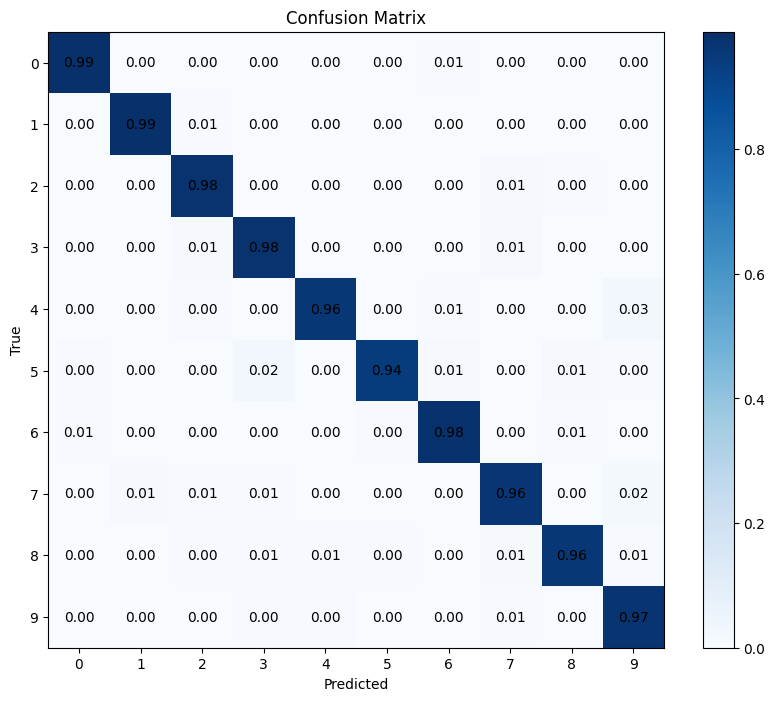

In [82]:
# confusion_Matrix

# Example values for demonstration
num_classes = len(class_names)
y_true = np.argmax(Y_test, axis=0)
y_predicted = np.argmax(Y_hat_test, axis=0)

# Initialize variables for confusion matrix
confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)

# Calculate confusion matrix
for i in range(num_classes):
    for j in range(num_classes):
        confusion_matrix[i, j] = np.sum((y_true == i) & (y_predicted == j))
# Normalize confusion matrix
confusion_matrix = confusion_matrix / confusion_matrix.sum(axis=1, keepdims=True)
# Plot confusion matrix

# Set figure size
plt.figure(figsize=(10, 8))
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add labels
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(np.arange(num_classes))
plt.yticks(np.arange(num_classes))


# Add text annotations with formatted values
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, "{:.2f}".format(confusion_matrix[i, j]), horizontalalignment='center', verticalalignment='center')


plt.show()



### Hyperparameter 2

In [83]:
from keras.datasets import mnist
(X, y), (X_test, y_test) = mnist.load_data()
class_names= ['No: 0', 'No: 1', 'No: 2', 'No: 3', 'No: 4', 'No: 5', 'No: 6', 'No: 7', 'No: 8', 'No: 9']
X_train, X_val, X_test, Y_train, Y_val, Y_test= Data_Preprocessing(X, y, X_test, y_test, class_names)

learning_rate= 0.0001
af_type= 'tanh'
weight_init_mode= 'Xavier'
optimizer= 'nadam'
batch_size= 64
loss_type= 'cross_entropy'
epochs= 10
lambda_reg= 0.0005
K_classes= len(class_names)
N_neurons= 128
N_layers= 3
N_features= X_train.shape[0]
dimensions= [N_features] + [N_neurons]*N_layers + [K_classes]
fit_model = model_fit(X_train, Y_train, X_val, Y_val, learning_rate, lambda_reg, af_type, weight_init_mode, optimizer, batch_size, loss_type, epochs, dimensions, 0.5, 0.5, 0.5)
parameters= fit_model.fit()

For the epoch: 0,training loss: 0.5646680093932358, validation loss: 0.4464318695322167, training accuracy: 91.38958333333333% and validation accuracy: 91.38958333333333%
For the epoch: 1,training loss: 0.4919495074411032, validation loss: 0.37578500645504975, training accuracy: 92.78541666666666% and validation accuracy: 92.78541666666666%
For the epoch: 2,training loss: 0.4518363583028998, validation loss: 0.3370411207981203, training accuracy: 93.65416666666667% and validation accuracy: 93.65416666666667%
For the epoch: 3,training loss: 0.42200777564430053, validation loss: 0.30821368335180077, training accuracy: 94.30625% and validation accuracy: 94.30625%
For the epoch: 4,training loss: 0.39775570560504364, validation loss: 0.2849123794839746, training accuracy: 94.84166666666667% and validation accuracy: 94.84166666666667%
For the epoch: 5,training loss: 0.37744878943476146, validation loss: 0.26561201807842816, training accuracy: 95.29166666666666% and validation accuracy: 95.29

In [84]:
Y_hat_train, _, _= fit_model.Feed_Forward_Network(X_train, parameters)
loss_train= fit_model.compute_true_error(Y_train, Y_hat_train, parameters)
Y_hat_test,_,_= fit_model.Feed_Forward_Network(X_test, parameters)
loss_test= fit_model.compute_test_error(Y_test, Y_hat_test)

# Compute the accuracy on the test set
train_acc = (np.argmax(Y_train, axis=0) == np.argmax(Y_hat_train, axis=0)).mean() *100
test_acc= (np.argmax(Y_test, axis=0) == np.argmax(Y_hat_test, axis=0)).mean() *100
accuracy_test = (np.argmax(Y_test, axis=0) == np.argmax(Y_hat_test, axis=0)).mean()

print(f"Accuracy Train: {train_acc}, Accuracy Test: {test_acc} and Train Loss: {loss_train}, Test Loss: {loss_test}")

Accuracy Train: 96.56666666666666, Accuracy Test: 95.94 and Train Loss: 0.3215562599898705, Test Loss: 0.19309550604640643


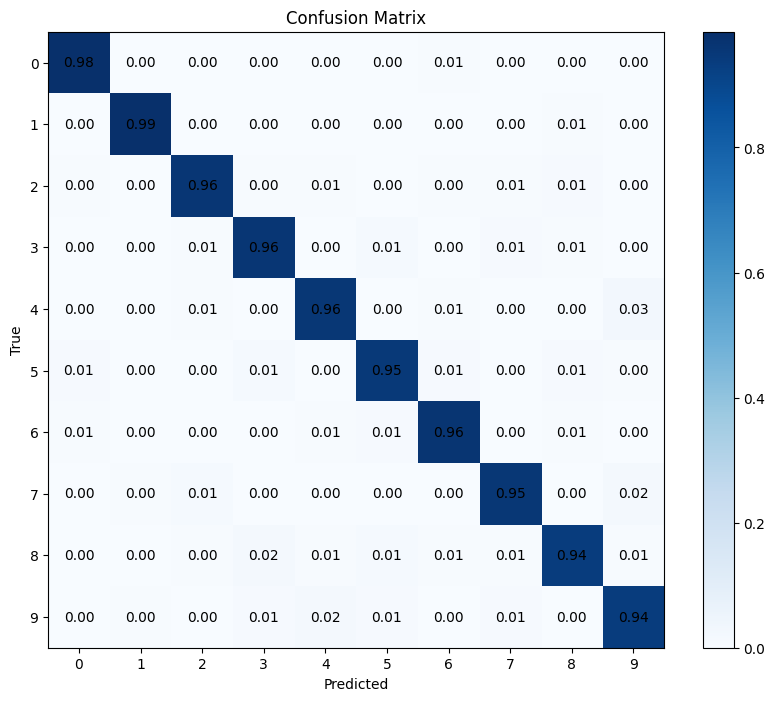

In [85]:
# confusion_Matrix

# Example values for demonstration
num_classes = len(class_names)
y_true = np.argmax(Y_test, axis=0)
y_predicted = np.argmax(Y_hat_test, axis=0)

# Initialize variables for confusion matrix
confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)

# Calculate confusion matrix

for i in range(num_classes):
    for j in range(num_classes):
        confusion_matrix[i, j] = np.sum((y_true == i) & (y_predicted == j))
# Normalize confusion matrix
confusion_matrix = confusion_matrix / confusion_matrix.sum(axis=1, keepdims=True)
# Plot confusion matrix using matplotlib
# Set figure size
plt.figure(figsize=(10, 8))
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add labels
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(np.arange(num_classes))
plt.yticks(np.arange(num_classes))

# Add text annotations with formatted values
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, "{:.2f}".format(confusion_matrix[i, j]), horizontalalignment='center', verticalalignment='center')


plt.show()



In [86]:
from keras.datasets import mnist
(X, y), (X_test, y_test) = mnist.load_data()
class_names= ['No: 0', 'No: 1', 'No: 2', 'No: 3', 'No: 4', 'No: 5', 'No: 6', 'No: 7', 'No: 8', 'No: 9']
X_train, X_val, X_test, Y_train, Y_val, Y_test= Data_Preprocessing(X, y, X_test, y_test, class_names)

learning_rate= 0.001
af_type= 'tanh'
weight_init_mode= 'Xavier'
optimizer= 'rmsprop'
batch_size= 64
loss_type= 'mean_squared_error'
epochs= 10
lambda_reg= 0.0005
K_classes= len(class_names)
N_neurons= 64
N_layers= 5
N_features= X_train.shape[0]
dimensions= [N_features] + [N_neurons]*N_layers + [K_classes]
fit_model = model_fit(X_train, Y_train, X_val, Y_val, learning_rate, lambda_reg, af_type, weight_init_mode, optimizer, batch_size, loss_type, epochs, dimensions, 0.5, 0.5, 0.5)
parameters= fit_model.fit()

For the epoch: 0,training loss: 0.16209408764418326, validation loss: 0.05354922615103718, training accuracy: 93.72083333333333% and validation accuracy: 93.72083333333333%
For the epoch: 1,training loss: 0.15479617192705067, validation loss: 0.041139652054337845, training accuracy: 95.43541666666667% and validation accuracy: 95.43541666666667%
For the epoch: 2,training loss: 0.1552775086937973, validation loss: 0.0388923108257972, training accuracy: 96.0% and validation accuracy: 96.0%
For the epoch: 3,training loss: 0.15428232878783352, validation loss: 0.035687483206598106, training accuracy: 96.65833333333333% and validation accuracy: 96.65833333333333%
For the epoch: 4,training loss: 0.15220013824436368, validation loss: 0.030889796202757683, training accuracy: 97.35208333333333% and validation accuracy: 97.35208333333333%
For the epoch: 5,training loss: 0.15173444407851486, validation loss: 0.027632819155181267, training accuracy: 97.8125% and validation accuracy: 97.8125%
For th

In [87]:
Y_hat_train, _, _= fit_model.Feed_Forward_Network(X_train, parameters)
loss_train= fit_model.compute_true_error(Y_train, Y_hat_train, parameters)
Y_hat_test,_,_= fit_model.Feed_Forward_Network(X_test, parameters)
loss_test= fit_model.compute_test_error(Y_test, Y_hat_test)

# Compute the accuracy on the test set
train_acc = (np.argmax(Y_train, axis=0) == np.argmax(Y_hat_train, axis=0)).mean() *100
test_acc= (np.argmax(Y_test, axis=0) == np.argmax(Y_hat_test, axis=0)).mean() *100
accuracy_test = (np.argmax(Y_test, axis=0) == np.argmax(Y_hat_test, axis=0)).mean()

print(f"Accuracy Train: {train_acc}, Accuracy Test: {test_acc} and Train Loss: {loss_train}, Test Loss: {loss_test}")

Accuracy Train: 98.49791666666667, Accuracy Test: 96.85000000000001 and Train Loss: 0.15653548833640427, Test Loss: 0.02407034237128829


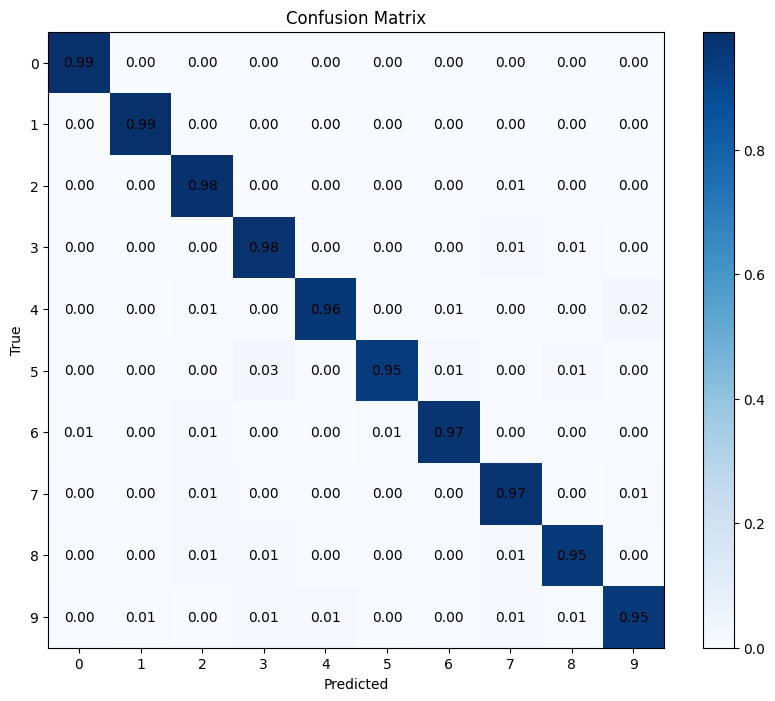

In [88]:
# confusion_Matrix

# Example values for demonstration
num_classes = len(class_names)
y_true = np.argmax(Y_test, axis=0)
y_predicted = np.argmax(Y_hat_test, axis=0)

# Initialize variables for confusion matrix
confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)

# Calculate confusion matrix
for i in range(num_classes):
    for j in range(num_classes):
        confusion_matrix[i, j] = np.sum((y_true == i) & (y_predicted == j))
# Normalize confusion matrix
confusion_matrix = confusion_matrix / confusion_matrix.sum(axis=1, keepdims=True)
# Plot confusion matrix using matplotlib
# Set figure size
plt.figure(figsize=(10, 8))
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add labels
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(np.arange(num_classes))
plt.yticks(np.arange(num_classes))

# Add text annotations with formatted values
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, "{:.2f}".format(confusion_matrix[i, j]), horizontalalignment='center', verticalalignment='center')


plt.show()